![](http://https://api-manager.universia.net/coreplatform-document-management/api/document-management/public/3l6wykk6kjryvb)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import pickle
import seaborn as sns
import gc

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/santander-customer-transaction-prediction/train.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv
/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv


In [2]:
sns.set_context("paper")
sns.set_style("darkgrid")

In [3]:
# training data
train = pd.read_csv('../input/santander-customer-transaction-prediction/train.csv')

In [4]:
# testing data
test = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv')

In [5]:
# submission example
ss = pd.read_csv('../input/santander-customer-transaction-prediction/sample_submission.csv')

In [6]:
test.shape

(200000, 201)

In [7]:
train.shape

(200000, 202)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB


In [10]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [11]:
train.isnull().any().any()

False

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


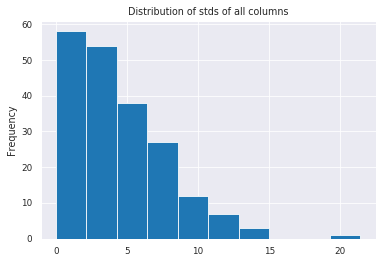

In [12]:
train[train.columns[2:]].std().plot('hist');
plt.title('Distribution of stds of all columns');

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


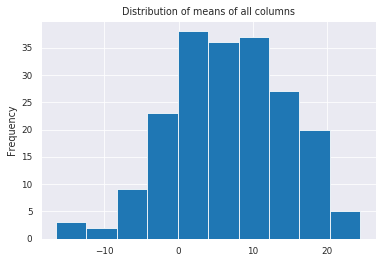

In [13]:
train[train.columns[2:]].mean().plot('hist');
plt.title('Distribution of means of all columns');

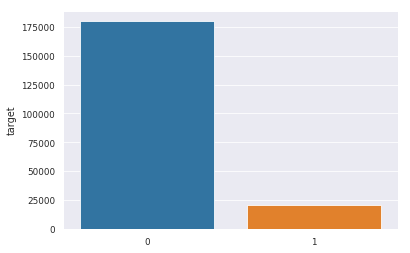

In [14]:
sns.barplot(x=train.target.value_counts().index, y=train.target.value_counts())

In [15]:
cor = train.corr()

In [16]:
cor

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
target,1.000000,0.052390,0.050343,0.055870,0.011055,0.010915,0.030979,0.066731,-0.003025,0.019584,...,0.055973,0.047114,-0.042858,-0.017709,-0.022838,0.028285,0.023608,-0.035303,-0.053000,0.025434
var_0,0.052390,1.000000,-0.000544,0.006573,0.003801,0.001326,0.003046,0.006983,0.002429,0.004962,...,0.002752,0.000206,-0.005373,0.001616,-0.001514,0.002073,0.004386,-0.000753,-0.005776,0.003850
var_1,0.050343,-0.000544,1.000000,0.003980,0.000010,0.000303,-0.000902,0.003258,0.001511,0.004098,...,0.006627,0.003621,-0.002604,0.001153,-0.002557,-0.000785,-0.000377,-0.004157,-0.004861,0.002287
var_2,0.055870,0.006573,0.003980,1.000000,0.001001,0.000723,0.001569,0.000883,-0.000991,0.002648,...,0.000197,0.001285,-0.003400,0.000549,0.002104,-0.001070,0.003952,0.001078,-0.000877,0.003855
var_3,0.011055,0.003801,0.000010,0.001001,1.000000,-0.000322,0.003253,-0.000774,0.002500,0.003553,...,0.000151,0.002445,-0.001530,-0.001699,-0.001054,0.001206,-0.002800,0.001164,-0.001651,0.000506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.028285,0.002073,-0.000785,-0.001070,0.001206,0.003706,-0.001274,0.001244,0.001854,0.001396,...,0.004571,0.000870,-0.004745,-0.003143,-0.001201,1.000000,0.002517,-0.004170,-0.000536,0.002042
var_196,0.023608,0.004386,-0.000377,0.003952,-0.002800,0.000513,0.002880,0.005378,0.001045,-0.003242,...,-0.000847,0.002466,-0.001386,-0.005308,-0.005040,0.002517,1.000000,-0.000454,0.000253,0.000607
var_197,-0.035303,-0.000753,-0.004157,0.001078,0.001164,-0.000046,-0.000535,-0.003565,0.003466,-0.004583,...,-0.004974,0.000906,-0.000527,0.005068,0.000884,-0.004170,-0.000454,1.000000,0.001183,0.004991
var_198,-0.053000,-0.005776,-0.004861,-0.000877,-0.001651,-0.001821,-0.000953,-0.003025,0.000650,0.002950,...,-0.000153,-0.000067,0.003451,0.001646,0.003194,-0.000536,0.000253,0.001183,1.000000,-0.004731


* ###### Проверим коэффициент корреляции чтобы узнать какие признаки имеют наибольшую связь с target.

In [17]:
#Correlation with output variable
cor_target = abs(cor["target"])

In [18]:
cor_target = cor_target.sort_values(kind='quicksort',ascending=False)
#Selecting highly correlated features
relevant_features = cor_target[1:31]
print(cor_target.mean())
relevant_features

0.032695193746120364


var_81     0.080917
var_139    0.074080
var_12     0.069489
var_6      0.066731
var_110    0.064275
var_146    0.063644
var_53     0.063399
var_26     0.062422
var_76     0.061917
var_174    0.061669
var_22     0.060558
var_21     0.058483
var_99     0.058367
var_166    0.057773
var_80     0.057609
var_190    0.055973
var_2      0.055870
var_165    0.055734
var_13     0.055156
var_148    0.055011
var_133    0.054548
var_198    0.053000
var_34     0.052692
var_0      0.052390
var_1      0.050343
var_115    0.050174
var_179    0.050002
var_109    0.049926
var_40     0.049530
var_44     0.049039
Name: target, dtype: float64

# Сравнение тестовых и тренировочных данных 

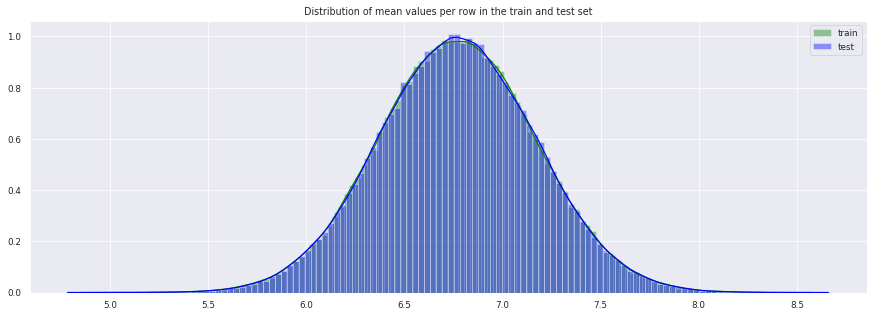

In [19]:
plt.figure(figsize=(15,5))
features = train.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

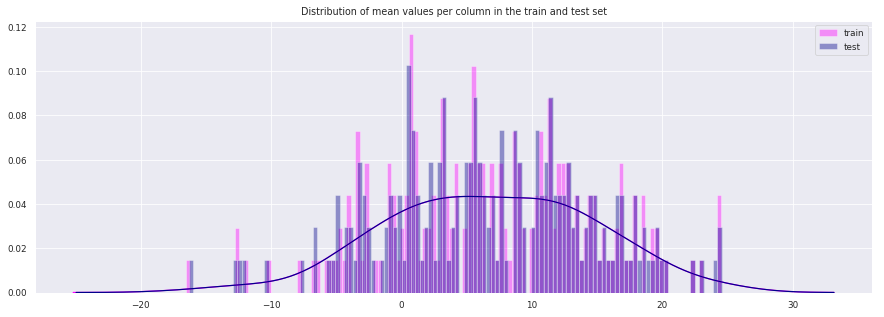

In [20]:
plt.figure(figsize=(15,5))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

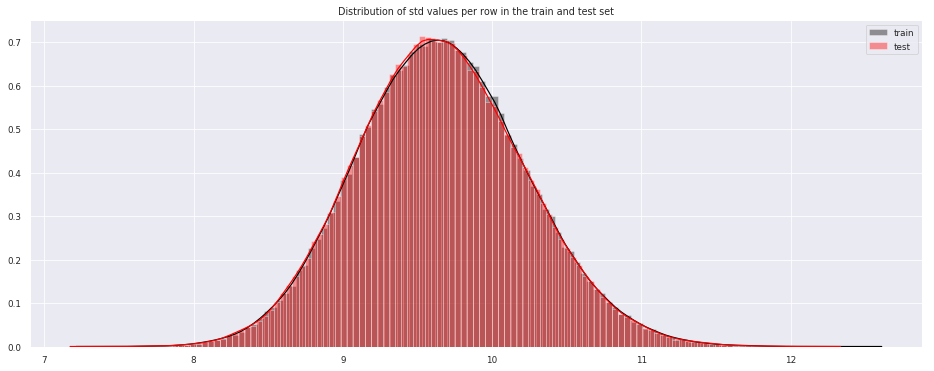

In [21]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

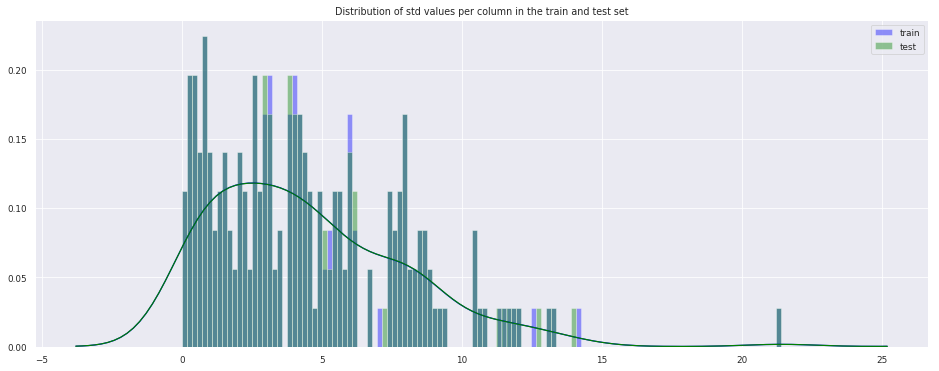

In [22]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

### Сравнение 0 и 1 в target

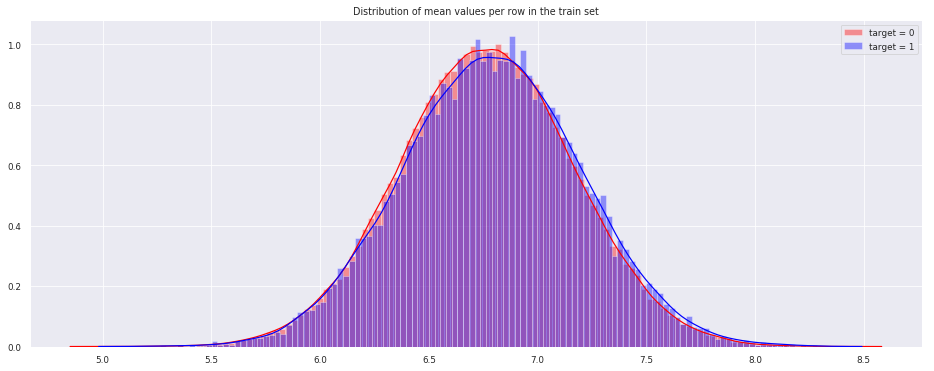

In [23]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

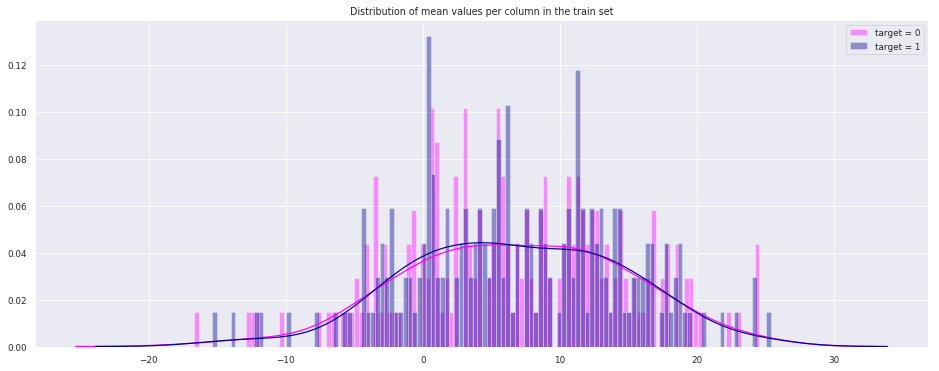

In [24]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="magenta", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

# Data pre-processing

In [25]:
X_train = train.drop(columns=['target','ID_code'])
y_train = train['target']

In [26]:
y_train.value_counts()

0    179902
1     20098
Name: target, dtype: int64

# XGBoost

In [27]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score, precision_score, recall_score, confusion_matrix
import xgboost as xgb

##### Параметры для XGboost

In [28]:
# details: https://xgboost.readthedocs.io/en/latest/parameter.html
params = {'tree_method': 'hist',
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'learning_rate': 0.0936165921314771,
 'max_depth': 2,
 'colsample_bytree': 0.3561271102144279,
 'subsample': 0.8246604621518232,
 'min_child_weight': 53,
 'gamma': 9.943467991283027,
 'silent': 1}

In [29]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

> > Чтобы сохранить распределение классов при разбивке, я использовал sklearn.model_selection.StratifiedKFold. Это важно, если классы изначально сильно несбалансированы (0 в девять раз больше чем 1 в train set)

In [30]:
%%time

oof_preds = np.zeros(train.shape[0])
sub_preds = np.zeros(test.shape[0])

feature_importance_df = pd.DataFrame()

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    
    trn_x, trn_y = train[features].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y_train.iloc[val_idx]
    
    dtrain = xgb.DMatrix(trn_x, trn_y, feature_names=trn_x.columns)
    dval = xgb.DMatrix(val_x, val_y, feature_names=val_x.columns)
    
    clf = xgb.train(params=params, dtrain=dtrain, num_boost_round=4000, evals=[(dtrain, "Train"), (dval, "Val")],
        verbose_eval= 100, early_stopping_rounds=50) 
    
    oof_preds[val_idx] = clf.predict(xgb.DMatrix(val_x))
    sub_preds += clf.predict(xgb.DMatrix(test[features])) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
    fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('\nFold %1d AUC %.6f & std %.6f' %(n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx]), np.std([oof_preds[val_idx]])))
    print('Fold %1d Precision %.6f' %(n_fold + 1, precision_score(val_y, np.round(oof_preds[val_idx])) ))
    print('Fold %1d Recall %.6f' %(n_fold + 1, recall_score(val_y, np.round(oof_preds[val_idx]) )))
    print('Fold %1d F1 score %.6f' % (n_fold + 1,f1_score(val_y, np.round(oof_preds[val_idx]))))
    print('Fold %1d Kappa score %.6f\n' % (n_fold + 1,cohen_kappa_score(val_y, np.round(oof_preds[val_idx]))))
    gc.collect()

print('\nCV AUC score %.6f & std %.6f' % (roc_auc_score(y_train, oof_preds), np.std((oof_preds))))
print('CV Precision score %.6f' % (precision_score(y_train, np.round(oof_preds))))
print('CV Recall score %.6f' % (recall_score(y_train, np.round(oof_preds))))
print('CV F1 score %.6f' % (f1_score(y_train, np.round(oof_preds))))
print('CV Kappa score %.6f' % (cohen_kappa_score(y_train, np.round(oof_preds))))

[0]	Train-auc:0.57816	Val-auc:0.57975
Multiple eval metrics have been passed: 'Val-auc' will be used for early stopping.

Will train until Val-auc hasn't improved in 50 rounds.
[100]	Train-auc:0.82350	Val-auc:0.81152
[200]	Train-auc:0.86182	Val-auc:0.84629
[300]	Train-auc:0.88009	Val-auc:0.86225
[400]	Train-auc:0.89105	Val-auc:0.87178
[500]	Train-auc:0.89833	Val-auc:0.87764
[600]	Train-auc:0.90367	Val-auc:0.88085
[700]	Train-auc:0.90800	Val-auc:0.88399
[800]	Train-auc:0.91164	Val-auc:0.88673
[900]	Train-auc:0.91402	Val-auc:0.88850
[1000]	Train-auc:0.91654	Val-auc:0.88988
[1100]	Train-auc:0.91854	Val-auc:0.89110
[1200]	Train-auc:0.92004	Val-auc:0.89198
[1300]	Train-auc:0.92144	Val-auc:0.89260
[1400]	Train-auc:0.92268	Val-auc:0.89328
[1500]	Train-auc:0.92380	Val-auc:0.89366
[1600]	Train-auc:0.92471	Val-auc:0.89398
[1700]	Train-auc:0.92550	Val-auc:0.89421
[1800]	Train-auc:0.92617	Val-auc:0.89440
[1900]	Train-auc:0.92668	Val-auc:0.89452
[2000]	Train-auc:0.92718	Val-auc:0.89465
[2100]	Train

In [31]:
print(confusion_matrix(y_train, np.round(oof_preds)))

[[177869   2033]
 [ 13199   6899]]


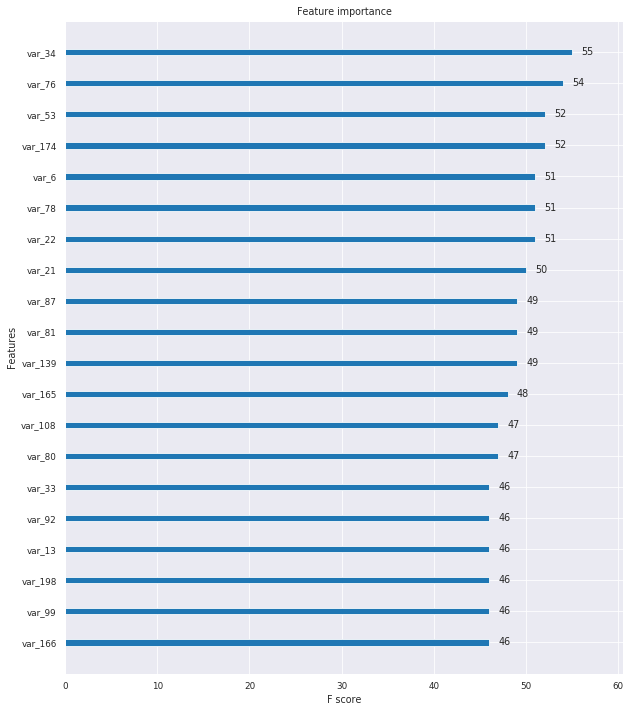

In [32]:
fig, ax = plt.subplots(1,1,figsize=(10,12)) 
xgb.plot_importance(clf, max_num_features=20, ax=ax)

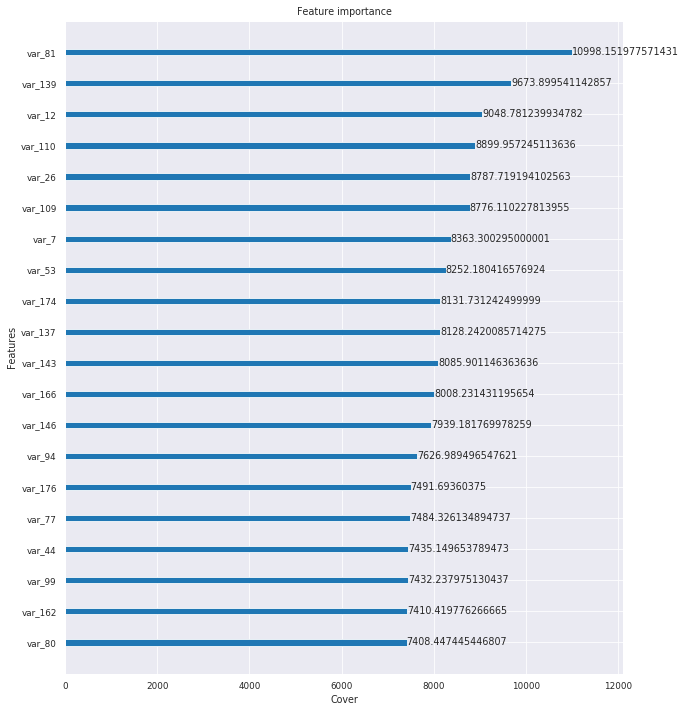

In [33]:
fig, ax = plt.subplots(1,1,figsize=(10,12)) 
xgb.plot_importance(clf, max_num_features=20, ax=ax, importance_type="cover", xlabel="Cover")

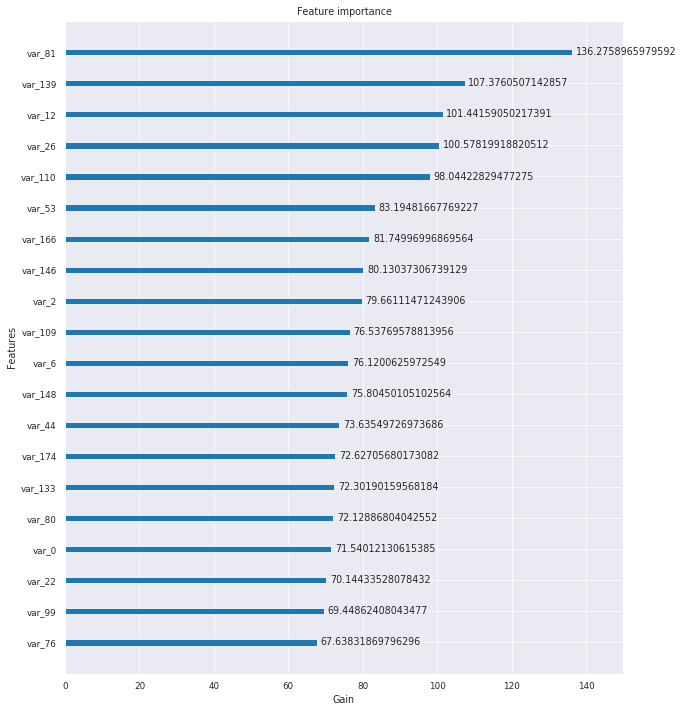

In [34]:
fig, ax = plt.subplots(1,1,figsize=(10,12)) 
xgb.plot_importance(clf, max_num_features=20, ax=ax, importance_type="gain", xlabel="Gain")

In [35]:
feature_importance_df.groupby(["feature"])["fscore",].mean().sort_values("fscore", ascending=False)

,fscore
feature,
var_34,54.60
var_53,51.40
var_174,49.60
var_6,49.00
var_76,49.00
...,...
var_185,2.20
var_96,1.80
var_117,1.75


In [36]:
test['target'] = sub_preds

In [37]:
oof_roc = roc_auc_score(y_train, oof_preds)
oof_roc 

0.8969705561623875

In [38]:
XGboost = pd.DataFrame({"ID_code":test["ID_code"], "target":test["target"]})
# XGboost.to_csv("xgb_Fold.csv"%(folds.n_splits, oof_roc), index=None)
XGboost.to_csv("xgb_submission.csv", index=None)
XGboost.head()

,ID_code,target
0,test_0,0.081889
1,test_1,0.245376
2,test_2,0.177256
3,test_3,0.202047
4,test_4,0.047565


In [39]:
XGboost.describe().T

,count,mean,std,min,25%,50%,75%,max
target,200000.0,0.091828,0.142034,0.000198,0.015149,0.038012,0.100041,0.999028


# Logistics regression 

In [40]:
X = train.drop(columns=['target','ID_code'])
y = train['target']

In [41]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

In [42]:
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.91


confusion matrix

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[53180   706]
 [ 4700  1414]]


In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     53886
           1       0.67      0.23      0.34      6114

    accuracy                           0.91     60000
   macro avg       0.79      0.61      0.65     60000
weighted avg       0.89      0.91      0.89     60000



### ROC Curve

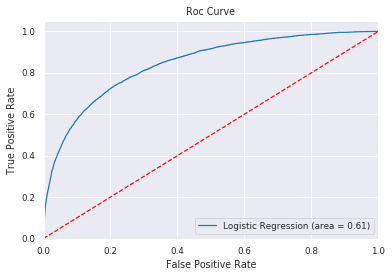

In [47]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


Train/Test split results:
LogisticRegression accuracy is 0.910
LogisticRegression log_loss is 0.244
LogisticRegression auc is 0.843


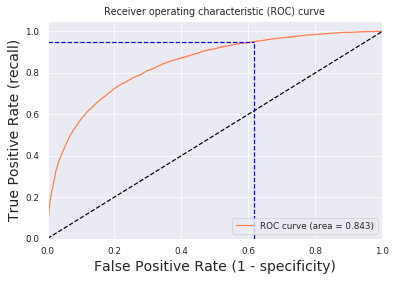

Using a threshold of 0.024 guarantees a sensitivity of 0.950 and a specificity of 0.384, i.e. a false positive rate of 61.55%.


In [48]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

In [49]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197,0.081889
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760,0.245376
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794,0.177256
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108,0.202047
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846,0.047565


In [50]:
# testing data
test = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv')

In [51]:
logist_pred = clf.predict_proba(test.drop(columns=['ID_code']))
sample = pd.DataFrame({'ID_code':test['ID_code'], 'target': logist_pred[:, 1]})
sample.to_csv('log_reg.csv', index = False)

AttributeError: 'Booster' object has no attribute 'predict_proba'

In [52]:
logist_pred[:, 1]

NameError: name 'logist_pred' is not defined

In [53]:
ss = pd.DataFrame({'ID_code':test['ID_code'], 'target': logist_pred[:, 1]})

NameError: name 'logist_pred' is not defined

In [54]:
ss.to_csv('logreg_.csv', index = False)

In [55]:
ss.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


# Decission Tree

In [56]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn import metrics 

In [57]:
clf = DecisionTreeClassifier()

clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

In [58]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8338


In [59]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[48764  5122]
 [ 4850  1264]]


In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91     53886
           1       0.20      0.21      0.20      6114

    accuracy                           0.83     60000
   macro avg       0.55      0.56      0.55     60000
weighted avg       0.84      0.83      0.84     60000



In [61]:
Acc = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(Acc))

Accuracy: 0.8338


In [62]:
cm = confusion_matrix

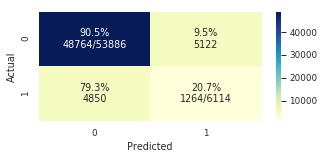

In [63]:
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)

cm = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

fig, ax = plt.subplots(figsize=[5,2])

sns.heatmap(cm, cmap= "YlGnBu", annot= annot, fmt='', ax=ax)

In [64]:
logist_pred = clf.predict_proba(test.drop(columns=['ID_code']))
ss = pd.DataFrame({'ID_code':test['ID_code'], 'target': logist_pred[:, 1]})
ss.to_csv('dec_tree.csv', index = False)

# Naive Bayes

In [65]:
from sklearn.naive_bayes import GaussianNB

In [66]:
gnb = GaussianNB()

In [67]:
gnb.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [68]:
GaussianNB(priors=None)

GaussianNB(priors=None, var_smoothing=1e-09)

In [69]:
gnb.score(X_train,y_train)

0.92275

In [70]:
y_pred = gnb.predict(X_test)

In [71]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[52973   913]
 [ 3922  2192]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     53886
           1       0.71      0.36      0.48      6114

    accuracy                           0.92     60000
   macro avg       0.82      0.67      0.72     60000
weighted avg       0.91      0.92      0.91     60000



In [72]:
logist_pred = gnb.predict_proba(test.drop(columns=['ID_code']))
ss = pd.DataFrame({'ID_code':test['ID_code'], 'target': logist_pred[:, 1]})
ss.to_csv('bayes.csv', index = False)